# Assignment 3
## Shuang Zhao

## Part 1

In [1]:
!python -V

Python 3.7.7


In [98]:
# import packages
# pip install tensorflow
# !pip install tensorflow_hub
import numpy as np
import pandas as pd
from numpy.random import seed
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow_hub as hub
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

In [3]:
# set the random seed
seed(1234)
tf.random.set_seed(1234) # do not use # tf.set_random_seed(seed = 1234)

### Question 2: 
Load the data\
How many training and test observations do you have?

In [4]:
# load training data
train = pd.read_csv('train.tsv',sep='\t', header=None)
test = pd.read_csv('test.tsv',sep='\t', header=None)

In [5]:
# check the dataframe
train.head(1)

,0,1
0,8.0,dear caps1 caps2 people world use coumputers k...


In [6]:
# name the columns
train.columns =['grade','content']
test.columns =['grade','content']

In [7]:
train.head(1)

,grade,content
0,8.0,dear caps1 caps2 people world use coumputers k...


In [8]:
train.shape

(1515, 2)

In [9]:
test.shape

(268, 2)

### Answer
Training data: 1,515 observations\
Test data: 268 observations

### Question 3: 
Create a vector of training labels. What does the distribution of labels look like for the training
set and the test set? Comment on what you see.

In [10]:
train_label = train.grade

Text(0.5, 1.0, 'Distribution of traning labels')

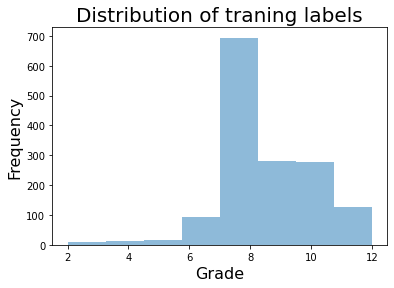

In [11]:
train_label.plot.hist(bins=8, alpha=0.5)
plt.xlabel('Grade', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of traning labels', fontsize = 20)

In [12]:
test_label = test.grade

Text(0.5, 1.0, 'Distribution of test labels')

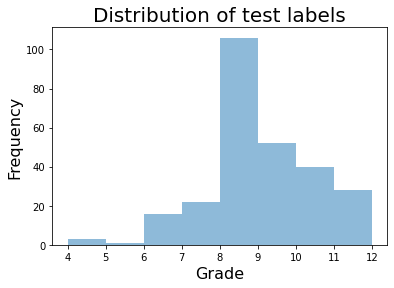

In [13]:
test_label.plot.hist(bins=8, alpha=0.5)
plt.xlabel('Grade', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.title('Distribution of test labels', fontsize = 20)

**Answer:**

The distribution of training labels is left-skewed. The mode of the training labels is 7.

The distribution of test labels is also left-skewed with a mode around 8.

### Question 4: 
Convert the training data to lower case. \
Remove punctuation from the training data. \
Also remove stop words from the training data using the NLTK package's English stop word list. \
In addition to NLTK's stopwords, are there words specific to this dataset that may be worthwhile
to treat as stop words? What are these words and why would you exclude them? Remove
these additional stop words from the training data as well (note: you can also remove this
secondary set of stop words after tokenizing. However, keep in mind that this may cause
feature alignment issues with your test dataset when you tokenize it.)

**Lowercase and remove punctuations**

In [14]:
def text_clean(text):
    text = text.lower() # lowercase
    text = re.sub(r"[^\w\s]", '',text) #remove puntucation
    text = re.sub(r"\s+", ' ',text) #remove multiple space
    return text

In [15]:
train['clean_text'] = train.content.apply(text_clean)

**Remove stop words**

In addition to NLTK's stopwords, are there words specific to this dataset that may be worthwhile to treat as stop words? What are these words and why would you exclude them?

**Answer**

- The words "dear", "caps1", "caps2"... "num1", "date1","organization1" are also removed.

Reason: 
- These words do not provide information about the quality of the essays.

Approach: 
- Add "dear" to the stop words list and remove it along with other stop words.
- For words like "caps1", "num1", create regular expressions, then remove them from the essay.

In [16]:
stop_words = stopwords.words('english')

In [17]:
# Remove puntuaction from stopwords
pattern_punc = "[^\w\s]"
for i in range(len(stop_words)):
    stop_words[i] = re.sub(pattern_punc, '', stop_words[i])

In [18]:
# Additional words to exclude
add = ['dear']
stop_words_re = stop_words + add

In [19]:
pat_caps = "caps\d*"
pat_num = "num\d+"
pat_date = "date\d+"
pat_org = "organization\d+"
pat_per = "percent\d+"
pat_mulspace = "\s+"

def no_stopwords(text):
    text_tokens = word_tokenize(text)
    text_list_nostop = []
    for token in text_tokens:
        if token not in stop_words_re:
            text_list_nostop.append(token)
    text_nostop = ' '.join(text_list_nostop)
    text_nostop = re.sub(pat_caps, '',text_nostop)
    text_nostop = re.sub(pat_num, '',text_nostop)
    text_nostop = re.sub(pat_date, '',text_nostop)
    text_nostop = re.sub(pat_org, '',text_nostop)
    text_nostop = re.sub(pat_per, '',text_nostop)
    text_nostop = re.sub(pat_mulspace, ' ',text_nostop)
    return text_nostop

In [20]:
# test
print(no_stopwords('i am very caps1 caps10 and the dear num1 date2 percent10 dear good bad'))

 good bad


In [21]:
train['clean_text_nostop'] = train.clean_text.apply(no_stopwords)

In [22]:
train.head()

,grade,content,clean_text,clean_text_nostop
0,8.0,dear caps1 caps2 people world use coumputers k...,dear caps1 caps2 people world use coumputers k...,people world use coumputers know computers us...
1,10.0,dear newspaper believe advances technology man...,dear newspaper believe advances technology man...,newspaper believe advances technology many pos...
2,6.0,think caps1s use computers help selfs using co...,think caps1s use computers help selfs using co...,think s use computers help selfs using compute...
3,9.0,want child suceed life computers valuable ever...,want child suceed life computers valuable ever...,want child suceed life computers valuable ever...
4,8.0,dear local newspaper computers important peopl...,dear local newspaper computers important peopl...,local newspaper computers important people eve...


### Question 5
- Stem/lemmatize your training data using a stemmer/lemmatizer of your choosing. 
- Show a before and after using a few observations and comment on what you see.

In [23]:
import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])

In [24]:
def lemma_text(text):
    doc = nlp(text)
    lemma_text = " ".join([token.lemma_ for token in doc])
    return lemma_text

In [25]:
train['lemma_text'] = train.clean_text_nostop.apply(lemma_text)

##### Comparison #1

In [26]:
train['clean_text_nostop'][0][0:100]

' people world use coumputers know computers used like surching internet games work school people thi'

In [27]:
train['lemma_text'][0][1:100]

' people world use coumputer know computer use like surche internet game work school people think co'

"Computers" become "computer", "used" become "use"

##### Comparison #2

In [28]:
train['clean_text_nostop'][10][1:100]

'computer wonderful thing however effects people bad think way magnetic forces pull people keep hour'

In [29]:
train['lemma_text'][10][0:100]

'  computer wonderful thing however effect people bad think way magnetic force pull people keep hour '

"Effects" become "effect"

**Comment:**

- The lemmatization function of Spacy convert words to their base forms.
- For example, "computers" become "computer","effects" become "effect", "heard" become "hear".

#### Question 6
- Tokenize your training data using unigrams (hint: see sklearn's CountVectorizer). 
- If you set upper and lower limits on word frequency, what are they? 
- How many unique tokens are in your vocabulary?

In [30]:
# Prepare the list to be tokenized
text_train = train['lemma_text']

In [89]:
# Set upper and lower limits on word frequency
vectorizer_limits = CountVectorizer(min_df=10, max_df=0.8) 
X_limits = vectorizer_limits.fit_transform(text_train)
X_limits.shape

(1515, 1529)

**When setting upper and lower limits**:

Set lower limit to 10, meaning exclude words that appeare less than 10 times.

Set upper limit to 0.8, meaning exclude words whose document frequency is larger than 0.8.

By doing so, there are 1,529 unigrams left.

In [31]:
# Tokenize by word/unigram, without any upper or lower limits
vectorizer = CountVectorizer(ngram_range = (1, 1))
X = vectorizer.fit_transform(text_train)
X.shape

(1515, 11893)

There are 11,896 unique tokens in the training data set if I do not set a limit for word frequency.

#### Question 7. 
- Process the test data in a manner identical to the training data. Note that you will need tohave the same dimensions for your training and test data. One way in which this can be done is using sklearn's CountVectorizer is to fit on the training data and transform the test data.
- Show that the number of features for your training and test data are identical.

In [32]:
# Clean the test data
test['clean_text'] = test.content.apply(text_clean)
# Remove stopwords
test['clean_text_nostop'] = test.clean_text.apply(no_stopwords)
# Lemmatize
test['lemma_text'] = test.clean_text_nostop.apply(lemma_text)

In [33]:
# Prepare the list to be tokenized
text_test = test['lemma_text']

In [34]:
# transform the test data
Y = vectorizer.transform(text_test)
Y.shape # test data

(268, 11893)

In [35]:
X.shape # training data

(1515, 11893)

Both the trainign data (X) and the test data (Y) have 11,896 features.

**Create the matrix of word frequency as features**

In [36]:
df_train_count = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
df_test_count = pd.DataFrame(Y.toarray(), columns=vectorizer.get_feature_names())

/Users/zhaoshuang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Part 2

#### Question 7
- In addition to the features you were tasked with generating in Part 1, design/build additional features of your choosing. 

- Describe the features that you ultimately used in your final models and articulate your reasoning for including the features that you did. 

    - Some potential ideas for additional features include bi-/trigrams, topic model weights, TF-IDF weights, sentiments, hand-engineered word co-occurrences (not adding any/all of these is completely  ne as well).

**Additional Features: TF-IDF weights**

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
# fit on the training data
text_train = train['lemma_text']
tf_vectorizer = TfidfVectorizer()
X_tf = tf_vectorizer.fit_transform(text_train)
X_tf.shape

(1515, 11893)

In [39]:
# transform on the test data
text_test = test['lemma_text']
Y_tf = tf_vectorizer.transform(text_test)
Y_tf.shape

(268, 11893)

**TF-IDF matrix for the training data set**

In [46]:
# Create new names for tf-idf features
new_columns = []
for i in tf_vectorizer.get_feature_names():
    new_columns.append('tf_'+i)
# Convert to a matrix
df_train_tf = pd.DataFrame(X_tf.toarray(), columns=new_columns)

**TF-IDF matrix for the test data set**

In [47]:
# Create new names for tf-idf features
new_columns = []
for i in tf_vectorizer.get_feature_names():
    new_columns.append('tf_'+i)
# Convert to a matrix
df_test_tf = pd.DataFrame(Y_tf.toarray(), columns=new_columns)

**Description of the additional features**

In [48]:
# training data
df_train_tf.describe()

,tf_aa,tf_aamous,tf_aare,tf_abad,tf_abandon,tf_abat,tf_abd,tf_abduction,tf_abe,tf_abease,...,tf_ìcomputer,tf_ìcyberspaceî,tf_ìgameî,tf_ìhuh,tf_ìin,tf_ìrealî,tf_ìtechî,tf_ìî,tf_ís,tf_ít
count,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,...,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000,1515.000000
mean,0.000180,0.000072,0.000148,0.000078,0.000068,0.000097,0.000060,0.000172,0.000089,0.000094,...,0.000059,0.000060,0.000066,0.000064,0.000060,0.000113,0.000070,0.000070,0.000181,0.000057
std,0.005048,0.002793,0.004096,0.003025,0.002629,0.003795,0.002333,0.004773,0.003458,0.003643,...,0.002305,0.002350,0.002568,0.002476,0.002350,0.004386,0.002728,0.002728,0.004102,0.002206
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.162997,0.108722,0.123379,0.117758,0.102310,0.147703,0.090795,0.146760,0.134601,0.141798,...,0.089709,0.091458,0.099944,0.096392,0.091458,0.170703,0.106172,0.106172,0.108617,0.085863


- The additional features are the TF-IDF weights of the tokens. There are 11,893 features, corresponding to the number of unique tokens in the training set.
- Due to the sparse nature of TF-IDF matrix, the mean value is close to 0 for all additinal features.

- Different from simple counts of tokens, TF-IDF matrix contains information on the importance of tokens. For example, the token "computer" appears frequently in essays, but it does not effectively indicate the quality of essays. By using TF-IDF, the importance of frequently used words get reduced, while the importance of less frequently used words increase. This help to differentiate among essays. Therefore, TF-IDF is a good feature to represent textual data.


**Combine word count features and tf-idf features for downstream analysis**

In [51]:
df_train = df_train_count.join(df_train_tf)
df_train.shape

(1515, 23786)

In [52]:
df_test = df_test_count.join(df_test_tf)
df_test.shape

(268, 23786)

#### Question 8
- To start, build a regularized linear regression model, Ridge.
- What was your regularization coefficient and how well does this model perform? 
- Are there any score ranges where it performs particularly well/poorly? 
    - Use graphs/tables where appropriate and contextualize results.

#### Build the Ridge model

In [126]:
from sklearn.linear_model import Ridge
# Initialize the Ridge model
clf = Ridge(alpha= 50)

In [127]:
# Fit the training data
clf.fit(df_train, train_label)

Ridge(alpha=50)

#### Show regularization coeffcients

In [128]:
clf.coef_

array([ 0.00120925, -0.01116135, -0.00673617, ..., -0.00047986,
        0.0008391 , -0.00069149])

In [129]:
clf.coef_.shape

(23786,)

#### Measuare perfomance

**1. Training data**

In [130]:
# predict the labels of training data
y_pred = clf.predict(df_train)
# compute the overall training error
np.sum((y_pred - train_label)**2)/len(train_label)

0.27171053716924837

The MSE of training data is 0.27.

In [134]:
# Put into dataframe
rslt_df = pd.DataFrame()
rslt_df['pred'] = y_pred
rslt_df['true'] = train_label
rslt_df['se'] = (rslt_df['pred'] - rslt_df['true'])**2
# Group by training labels (integers)
rslt_df2 = rslt_df.groupby(['true']).agg(
    group_mse = ('se','mean'))

**2. Test data**

In [132]:
# predict the labels
y_test_pred = clf.predict(df_test)
# compute the overall test error
np.sum((y_test_pred - test_label)**2)/len(test_label)

1.0408512664114502

The MSE of test data is 1.04.

**Table of test MSE by true labels**

In [135]:
# Put into dataframe
rslt_df = pd.DataFrame()
rslt_df['pred'] = y_test_pred
rslt_df['true'] = test_label
rslt_df['se'] = (rslt_df['pred'] - rslt_df['true'])**2
# Group by training labels (integers)
rslt_df3 = rslt_df.groupby(['true']).agg(
    group_mse = ('se','mean'))

**Visualization of MSE of training and test data**

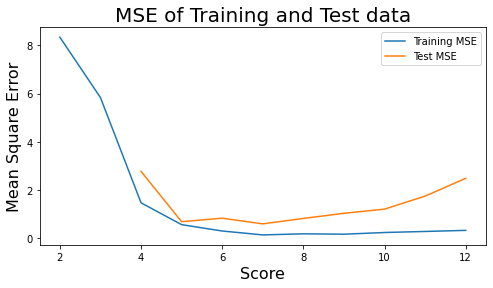

In [136]:
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(rslt_df2.index, rslt_df2['group_mse'], label = 'Training MSE')
plt.plot(rslt_df3.index, rslt_df3['group_mse'], label = "Test MSE")
plt.xlabel('Score', fontsize = 16)
plt.ylabel('Mean Square Error',fontsize = 16)
plt.title('MSE of Training and Test data',fontsize = 20)
plt.legend()
plt.show()

- The model performs well in score range from 6 to 8, and performs poorly in score range from 4 to 6. 
- This is due to the distribution of training data points. In the training data set, there are less data points in the range of 4 to 6 than the range from 6 to 8.

## Question 9. Next, build any model other than the ones you've already built. 
- Which model did you use and why? 
- Did you tune hyperparameters? If so, which ones and how? 
- Are there any scores where it performs particularly well? Are there any scores where it performs particularly poorly? 
    - Use graphs/tables where appropriate and contextualize results.

### Build a SVM model

**Reasoning**

- SVM model works well with unstructred data, such as texual data in this task.
- SVM model works well in classification tasks. In this case, the score of essays can be treated as groups since the scores are all integers.
- In this case, there are 23,786 features that result in high dimensional space. And SVM model can work with this type of high dimensional data. 

##### SVM benchmark model (without tuning hyperparamters)

In [111]:
clf = make_pipeline(StandardScaler(),LinearSVC(random_state=0, tol=1e-5))

In [112]:
# Fit the training data
clf.fit(df_train, train_label)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [113]:
# predict the labels
y_test_pred = clf.predict(df_test)
# compute the overall test error
np.sum((y_test_pred - test_label)**2)/len(test_label)

3.2276119402985075

The average training MSE is 3.23.

##### SVM Hyperparameter tuning using GridSearch

**Approach**
- I used GridSearch to tune the hyperparameters of "C", 'kernel' of SVM models.
- After running all combinations of the hyperparameters, the function of grid.predict() give the predicted value of the best performing SVM model.
- The average MSE for the best performing model is 1.22, smaller than the benchmark SVM model (3.23).

In [90]:
from sklearn.model_selection import GridSearchCV

In [102]:
model = SVC()
param_tuning_grid = {'C': [0.1, 1, 10, 100],'kernel': ['linear','poly','rbf','sigmoid']}

In [103]:
grid = GridSearchCV(SVC(), param_tuning_grid, refit = True, verbose = 3)

In [125]:
# Run this cell to test all combinations of hyperparameters.
# grid.fit(df_train, train_label)

In [105]:
print(grid.best_params_)

{'C': 1, 'kernel': 'rbf'}


In [106]:
# Predict the test labels with the best performing SVM model 
grid_predictions = grid.predict(df_test)

In [108]:
# compute the overall test error
np.sum((grid_predictions - test_label)**2)/len(test_label)

1.2201492537313432

#### Are there any scores where it performs particularly well? Are there any scores where it performs particularly poorly? 

In [120]:
# Put into dataframe
rslt_df = pd.DataFrame()
rslt_df['pred'] = grid_predictions
rslt_df['true'] = test_label
rslt_df['se'] = (rslt_df['pred'] - rslt_df['true'])**2
# Group by training labels (integers)
rslt_df5 = rslt_df.groupby(['true']).agg(
    group_mse = ('se','mean'))

In [121]:
rslt_df5

,group_mse
true,
4.0,8.000000
5.0,1.000000
6.0,2.750000
7.0,1.000000
8.0,0.339623
9.0,0.846154
10.0,1.650000
11.0,2.578947
12.0,4.555556


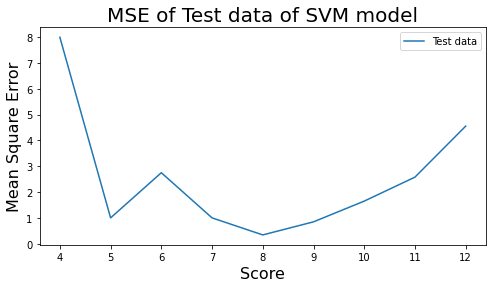

In [154]:
# Visualization of the test MSE of benchmark SVM model
plt.plot(rslt_df5.index, rslt_df5['group_mse'], label = "Test data")
plt.xlabel('Score', fontsize = 16)
plt.ylabel('Mean Square Error',fontsize = 16)
plt.title('MSE of Test data of SVM model',fontsize = 20)
plt.legend()
plt.show()

**Answer**

The SVM model performs poorly in the score range from 4 to 6, and 10 to 12.

And it performs best in the score of 8.

## Question 10. Compare the performance of the regressors you built.
- Which is the strongest? 
- Which is the weakest?

**Answer:**

- The strongest model is Ridge model, with the smallest test MSE of 1.04.

- The weakest model is the benchmark SVM model with no hyperparameter tuning, with the test MSE of 3.22.

# Part 3

## Question 13

State which model you chose and your thought process for choosing it versus the other models. 

**Answer:**

- I chose the Ridge model for this part.

- The reason is that Ridge model has the smallest test MSE, and it can deal with high dimensional features. 

## Question 14

You will be using Universal Sentence Encoder to embed the text data and get the dense feature vectors for the essays. First you need to import the model with the following codes:

In [144]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

## Question 15

Next, You will embed the data with the imported model. Universal Sentence Encoder takes a
list of strings and generates the embeddings of the sentence list. Assuming x train is a list of
the strings, here's how you get the embeddings of the strings:

In [145]:
# convert training data to a list of strings
x_train = train['lemma_text'].tolist()

In [146]:
# get the embeddings of the training strings
emb = model(x_train)

## Question 16

Next, feed the embeddings to the model you chose from the part 2. 

How does your model perform? 

Does it perform better than using TF-IDF features?

In [147]:
# feed to ridge 
clf = Ridge(alpha= 50)
clf.fit(emb, train_label)

Ridge(alpha=50)

### Model performance

**Training data**

In [148]:
# predict the labels
y_pred = clf.predict(emb)
# compute the overall training error
np.sum((y_pred - train_label)**2)/len(train_label)

1.6670270977351778

**Test data**

In [149]:
x_test = test['lemma_text'].tolist()

In [150]:
emb_test = model(x_test)

In [157]:
rslt_df = pd.DataFrame()
rslt_df['pred'] = y_test_pred
rslt_df['true'] = test_label
rslt_df['se'] = (rslt_df['pred'] - rslt_df['true'])**2
# Group by training labels (integers)
rslt_df6 = rslt_df.groupby(['true']).agg(
    group_mse = ('se','mean'))

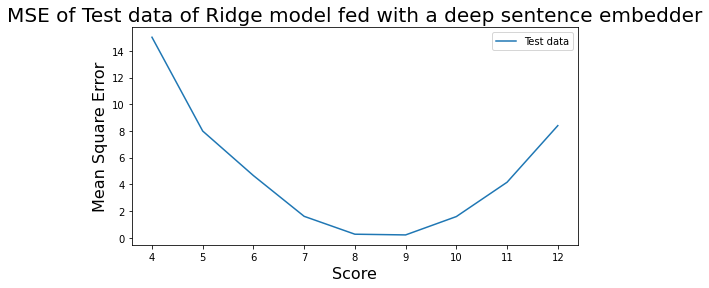

In [158]:
# Visualization of the test MSE of benchmark SVM model
plt.plot(rslt_df6.index, rslt_df6['group_mse'], label = "Test data")
plt.xlabel('Score', fontsize = 16)
plt.ylabel('Mean Square Error',fontsize = 16)
plt.title('MSE of Test data of Ridge model fed with a deep sentence embedder',fontsize = 20)
plt.legend()
plt.show()

The model performs well in the score rang of 8 to 9.

But it performs poorly in the score range of 4 to 7 and 10 to 12.

### Compare to TF-IDF features

In [160]:
# predict the labels
y_test_pred = clf.predict(emb_test)
# compute the overall test error
np.sum((y_test_pred - test_label)**2)/len(test_label)

1.5637203279026708

- The Ridge model fed with a deep sentence embedder has the test MSE of 1.56.
- The Ridge model fed with TF-IDF features has the test MSE of 1.04.


- So, the Ridge model fed with TF-IDF features in part 2 has better performance than this model in part 3.
